# Sentiment Analysis of Religious Texts

Books analyzed:
- The Bible
- The Koran
- The Bhagavad Gita
- The Tao Teh King
- The Dammapada

The books were downloaded in text format from Project Gutenberg.

## Importing Libraries

In [ ]:
!pip install tqdm

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import sys
from string import punctuation
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from gensim.parsing.preprocessing import remove_stopwords

In [ ]:
# entities = pd.read_csv("./outputs/document_entities_export.csv")

## Reading the files

In [26]:
import glob
filenames = []
texts = []
for filename in glob.glob('.\sentiment texts\*'):
    with open(filename, encoding='utf-8') as file:
        filenames.append(filename)
        text = file.read() 
        texts.append(text)

In [27]:
filenames

['.\\sentiment texts\\buddhism_Dammapada.txt',
 '.\\sentiment texts\\christianity_The Bible, King James Version, Complete.txt',
 '.\\sentiment texts\\hinduism_The Bhagavad Gita.txt',
 '.\\sentiment texts\\islam_The Koran.txt',
 '.\\sentiment texts\\taoism_The Tao Teh King.txt']

In [28]:
entities = pd.DataFrame(filenames, columns=['filename'])

In [29]:
entities.head()

,filename
0,.\sentiment texts\buddhism_Dammapada.txt
1,".\sentiment texts\christianity_The Bible, King..."
2,.\sentiment texts\hinduism_The Bhagavad Gita.txt
3,.\sentiment texts\islam_The Koran.txt
4,.\sentiment texts\taoism_The Tao Teh King.txt


In [30]:
entities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  5 non-null      object
dtypes: object(1)
memory usage: 168.0+ bytes


In [31]:
# entities = entities.groupby(['file']).agg('first').reset_index()
# # entities = entities.iloc[:1][:]
# entities.head()

In [32]:
def extract_religion(string):
    '''
    Extracting religion from filename
    '''
    return string.split("_")[0].split("\\")[-1]

In [33]:
entities["religion"] = entities["filename"].apply(extract_religion)

In [34]:
entities.loc[entities["religion"] == "jain", "religion"] = "jainism"

In [35]:
entities.religion.value_counts()

buddhism        1
taoism          1
christianity    1
hinduism        1
islam           1
Name: religion, dtype: int64

In [36]:
# def get_filename(file):
#     return file.split("/")[-1]

In [37]:
# entities["filename"] = entities["file"].apply(get_filename)
# entities.head()

In [38]:
def get_bookname(file):
    '''
    Extracting bookname from the filename
    '''
    return file.split("_")[-1].split(".")[0]

In [39]:
entities["bookname"] = entities["filename"].apply(get_bookname)
entities.head()

,filename,religion,bookname
0,.\sentiment texts\buddhism_Dammapada.txt,buddhism,Dammapada
1,".\sentiment texts\christianity_The Bible, King...",christianity,"The Bible, King James Version, Complete"
2,.\sentiment texts\hinduism_The Bhagavad Gita.txt,hinduism,The Bhagavad Gita
3,.\sentiment texts\islam_The Koran.txt,islam,The Koran
4,.\sentiment texts\taoism_The Tao Teh King.txt,taoism,The Tao Teh King


In [40]:
entities.bookname.value_counts()

The Koran                                  1
The Bible, King James Version, Complete    1
Dammapada                                  1
The Bhagavad Gita                          1
The Tao Teh King                           1
Name: bookname, dtype: int64

In [41]:
def get_text(filename):
    '''
    Reading text from each file
    '''
    with open(filename, "r", encoding="utf-8") as f:
        return f.read() 

In [42]:
entities["text"] = entities["filename"].apply(get_text)
entities.head()

,filename,religion,bookname,text
0,.\sentiment texts\buddhism_Dammapada.txt,buddhism,Dammapada,﻿The Project Gutenberg EBook of The Dhammapada...
1,".\sentiment texts\christianity_The Bible, King...",christianity,"The Bible, King James Version, Complete","﻿Project Gutenberg's The Bible, King James Ver..."
2,.\sentiment texts\hinduism_The Bhagavad Gita.txt,hinduism,The Bhagavad Gita,﻿The Project Gutenberg EBook of The Bhagavad-G...
3,.\sentiment texts\islam_The Koran.txt,islam,The Koran,﻿The Project Gutenberg Etext of The Koran as t...
4,.\sentiment texts\taoism_The Tao Teh King.txt,taoism,The Tao Teh King,"﻿The Project Gutenberg EBook of Tao Teh King, ..."


In [43]:
# entities.drop(["file", "label", "count"], axis=1, inplace=True)
# entities.head()

## Data Preprocessing

In [44]:
def clean_text(x):
    '''
    Cleaning text
    '''
    
    #Remove \n
    t = re.findall(r"\bSTART OF THIS PROJECT GUTENBERG EBOOK\b (.*) END OF THIS PROJECT GUTENBERG EBOOK", re.sub('[\*\n]', ' ', x), re.I)
    if t:
        x = t[0]
    else:
        x = re.sub('[\*\n]', ' ', x)

    #Remove \ufeff
    x = x.replace("\ufeff", " ")

    #Remove numbers
    x = re.sub(r'[0-9]+', '', x)

    #Remove Punctuation
    x = re.sub('[!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~]*', '', x)

    #Remove Roman Numerals
    # x = re.sub('/^M*(?:D?C{0,3}|C[MD])(?:L?X{0,3}|X[CL])(?:V?I{0,3}|I[XV])$/', '', x)

    #Remove Extra Spaces
    x = re.sub(' +', ' ', x)

    #Lowercasing
    x = x.lower()
    
    #Removing stopwords
    x = remove_stopwords(x)
    
    #Removing most and least frequent words
    freq = pd.Series(x.split()).value_counts()
    x = ' '.join([s for s in x.split() if (freq[s]>10 and freq[s]<300)])

    return x

In [45]:
# entities = entities.loc[entities.bookname=="The Bible, King James Version, Complete"].reset_index()
entities['text'] = entities['text'].apply(clean_text)
entities.head()

,filename,religion,bookname,text
0,.\sentiment texts\buddhism_Dammapada.txt,buddhism,Dammapada,chapter chapter earnestness chapter thought ch...
1,".\sentiment texts\christianity_The Bible, King...",christianity,"The Bible, King James Version, Complete",james andrew early james second desired table ...
2,.\sentiment texts\hinduism_The Bhagavad Gita.txt,hinduism,The Bhagavad Gita,bhagavadgita bhagavadgita arjuna prince suprem...
3,.\sentiment texts\islam_The Koran.txt,islam,The Koran,project gutenberg etext koran translated rodwe...
4,.\sentiment texts\taoism_The Tao Teh King.txt,taoism,The Tao Teh King,tao tao tao tao unchanging tao unchanging havi...


## Splitting each Text into 100 parts

In [46]:
# Split each routine into 100 parts
import numpy as np
import math

def split_text(text, n=100):
    '''
    Splitting the text into 100 parts
    '''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in tqdm(range(n)):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [47]:
# Let's create a list to hold all of the pieces of text
list_pieces = []
for t in tqdm(entities.text):
    split = split_text(t)
    list_pieces.append(split)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.85it/s]


In [48]:
df = pd.DataFrame(list_pieces)  

In [49]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,chapter chapter earnestness chapter thought ch...,ter chapter chapter self chapter world chapter...,pter chapter chapter way chapter chapter chapt...,hought thoughts thoughts man evil thought pain...,thoughts hatred hatred hatred hatred love wor...,g truth truth truth truth truth follow desires...,world sees evil man delights world delights d...,y happy good happy good path man law like law ...,estness earnestness path nirvana path death ea...,ghest happiness deeds lives earnestness restra...,...,ion hatred bhikshu body mind world called quie...,uiet nirvana desires happiness bhikshu buddha ...,ahmana restraint knowledge brahmana highest en...,ed brahmana called away called brahmana brahma...,y thought man law buddha let brahmana man brah...,free brahmana brahmana cut brahmana cut awaken...,hmana knows end brahmana knowledge knows way h...,nger hatred like brahmana true free brahmana w...,ood evil free grief brahmana like brahmana wor...,rahmana pleasure pain free life brahmana knows...
1,james andrew early james second desired table ...,m gomorrah bela joined salt served thirteenth ...,midian ephah abraham isaac concubines abraham ...,tants canaanites perizzites number gather slay...,ittle ones wives regard stuff joseph commandme...,pharaoh frogs died houses villages fields gath...,t break mount sinai mount sanctify break lest ...,llock skin dung burn camp ram ram slay ram spr...,th cubits hangings court pillars sockets brass...,resented pieces wash inwards legs goat slew of...,...,slain paul council chief captain morrow enquir...,died died liveth liveth likewise alive reign ...,hful remembrance ways teach church shortly spe...,nowledge sweet savour saved perish savour savo...,n paul apostle saints ephesus faithful grace s...,means tempted labour vain timotheus tidings fa...,king mention prayers hearing faith saints fait...,nowing faith worketh patience patience perfect...,itten strong abideth overcome world world worl...,t sixth angel sounded horns golden sixth angel...
2,bhagavadgita bhagavadgita arjuna prince suprem...,ok work religion knowledge religion works reli...,fold faith religion chapter wrought words vast...,set forth krishna divine fight slay son arjun...,t shall slay peace come o sin o thou men piety...,krishna hath thee nay thyself thy thyself thy...,th live lives come come wise know fear thy the...,spirit death hath man nay ones spirit flesh t...,ce great man life living things prince thou th...,son thine thy heart things thee fight thou sh...,...,light dark right action wrought love gain act...,wing nought mind truth prince evil right sees ...,sure pleasure soul pleasure senses tis prince ...,gs born nature lives spirit fight lord men bor...,son perfect peace brahm supreme highest heart...,mind live faith faith thou shalt grace thyself...,place hath thee truth mystery mystery thou ac...,o unto brahma nay shall ye man shall earth yea...,lord fixed thy speech krishna o heart wise gr...,religion fn fn sense fn fn fn desire fruit fn...
3,project gutenberg etext koran translated rodwe...,t fresh number desert tribes arabian nation cr...,ays m et et et idea mind islam true manner zai...,mmad information died ah works later informati...,aled histories doubt constant scripture histor...,ii p verse xxv p vii p xxix p dr p adopted ch...,on voice v nöld p life p revealed prophetic of...,r recited times prayers book praise thanks pra...,ly previous lit fish comp xxxvii xxi xviii mec...,believers torment faith mighty praiseworthy k...,...,ane view general animals calf soon let public ...,ul angels helpers haply away wives better musl...,lievers let laugh scorn haply better let women...,dels led error allow year forbid good number m...,rovided apostle act cause blame gracious merci...,assage xiii p n lit second old ibn verse refer...,kings gave given human beings enter holy land...,on mary messiah children israel worship join g...,rivers flow remain pleased great bli

In [50]:
cols = range(0,100)

In [51]:
entities = pd.concat([entities, df], axis=1, sort=False)
# entities.drop('index', axis=1, inplace=True)
entities.head()

,filename,religion,bookname,text,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,.\sentiment texts\buddhism_Dammapada.txt,buddhism,Dammapada,chapter chapter earnestness chapter thought ch...,chapter chapter earnestness chapter thought ch...,ter chapter chapter self chapter world chapter...,pter chapter chapter way chapter chapter chapt...,hought thoughts thoughts man evil thought pain...,thoughts hatred hatred hatred hatred love wor...,g truth truth truth truth truth follow desires...,...,ion hatred bhikshu body mind world called quie...,uiet nirvana desires happiness bhikshu buddha ...,ahmana restraint knowledge brahmana highest en...,ed brahmana called away called brahmana brahma...,y thought man law buddha let brahmana man brah...,free brahmana brahmana cut brahmana cut awaken...,hmana knows end brahmana knowledge knows way h...,nger hatred like brahmana true free brahmana w...,ood evil free grief brahmana like brahmana wor...,rahmana pleasure pain free life brahmana knows...
1,".\sentiment texts\christianity_The Bible, King...",christianity,"The Bible, King James Version, Complete",james andrew early james second desired table ...,james andrew early james second desired table ...,m gomorrah bela joined salt served thirteenth ...,midian ephah abraham isaac concubines abraham ...,tants canaanites perizzites number gather slay...,ittle ones wives regard stuff joseph commandme...,pharaoh frogs died houses villages fields gath...,...,slain paul council chief captain morrow enquir...,died died liveth liveth likewise alive reign ...,hful remembrance ways teach church shortly spe...,nowledge sweet savour saved perish savour savo...,n paul apostle saints ephesus faithful grace s...,means tempted labour vain timotheus tidings fa...,king mention prayers hearing faith saints fait...,nowing faith worketh patience patience perfect...,itten strong abideth overcome world world worl...,t sixth angel sounded horns golden sixth angel...
2,.\sentiment texts\hinduism_The Bhagavad Gita.txt,hinduism,The Bhagavad Gita,bhagavadgita bhagavadgita arjuna prince suprem...,bhagavadgita bhagavadgita arjuna prince suprem...,ok work religion knowledge religion works reli...,fold faith religion chapter wrought words vast...,set forth krishna divine fight slay son arjun...,t shall slay peace come o sin o thou men piety...,krishna hath thee nay thyself thy thyself thy...,...,light dark right action wrought love gain act...,wing nought mind truth prince evil right sees ...,sure pleasure soul pleasure senses tis prince ...,gs born nature lives spirit fight lord men bor...,son perfect peace brahm supreme highest heart...,mind live faith faith thou shalt grace thyself...,place hath thee truth mystery mystery thou ac...,o unto brahma nay shall ye man shall earth yea...,lord fixed thy speech krishna o heart wise gr...,religion fn fn sense fn fn fn desire fruit fn...
3,.\sentiment texts\islam_The Koran.txt,islam,The Koran,project gutenberg etext koran translated rodwe...,project gutenberg etext koran translated rodwe...,t fresh number desert tribes arabian nation cr...,ays m et et et idea mind islam true manner zai...,mmad information died ah works later informati...,aled histories doubt constant scripture histor...,ii p verse xxv p vii p xxix p dr p adopted ch...,...,ane view general animals calf soon let public ...,ul angels helpers haply away wives better musl...,lievers let laugh scorn haply better let women...,dels led error allow year forbid good number m...,rovided apostle act cause blame gracious merci...,assage xiii p n lit second old ibn verse refer...,kings gave given human beings enter holy land...,on mary messiah children israel worship join g...,rivers flow remain pleased great bliss unto he...,egypt pharaoh moses apostle vi xxxvii vi xxxvi...
4,.\sentiment texts\taoism_The Tao Teh King.txt,taoism,The Tao Teh King,tao tao tao tao unchanging tao unchanging havi...,tao tao tao tao unchanging tao unchanging h,aving heaven earth having things shall plac,e

In [52]:
entities = pd.melt(entities, id_vars=['text', 'religion', 'filename', 'bookname'])
entities = entities.sort_values(by=['bookname', 'variable']).reset_index()

In [54]:
entities.drop(['index', 'text', 'filename'], axis=1, inplace=True)
entities.columns = ['religion', 'book_name', 'chunk', 'text']
entities.head()

,religion,book_name,chunk,text
0,buddhism,Dammapada,0,chapter chapter earnestness chapter thought ch...
1,buddhism,Dammapada,1,ter chapter chapter self chapter world chapter...
2,buddhism,Dammapada,2,pter chapter chapter way chapter chapter chapt...
3,buddhism,Dammapada,3,hought thoughts thoughts man evil thought pain...
4,buddhism,Dammapada,4,thoughts hatred hatred hatred hatred love wor...


In [55]:
entities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   religion   500 non-null    object
 1   book_name  500 non-null    object
 2   chunk      500 non-null    object
 3   text       500 non-null    object
dtypes: object(4)
memory usage: 15.8+ KB


# Getting Sentiment Values

In [56]:
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    new_df = df.copy()

    filepath = ('./data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")

    
    book_name = ''
    chunk = ''
    
    with tqdm(total=len(list(new_df.iterrows())), file=sys.stdout) as pbar:
        for i, row in new_df.iterrows():
            pbar.update(1)
#             if row['book_name'] != book_name:
#                 print(row['book_name'])
#                 book_name = row['book_name']
#             if row['chunk'] != chunk:
#                 print('   ', row['chunk'])
#                 chunk = row['chunk']
#                 chunk = row['chunk']
            document = word_tokenize(new_df.loc[i][column])
            for word in document:
#                 word = stemmer.stem(word)
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]
            emo_df.loc[i, :] = emo_df.loc[i, :]/len(document)
    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df

In [57]:
entities_emotion = text_emotion(entities, 'text')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [17:57<00:00,  2.16s/it]


In [58]:
entities_emotion.head()

,religion,book_name,chunk,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,buddhism,Dammapada,0,chapter chapter earnestness chapter thought ch...,0.062500,0.0625,0.125000,0.062500,0.000000,0.125000,0.125000,0.062500,0.0000,0.0
1,buddhism,Dammapada,1,ter chapter chapter self chapter world chapter...,0.062500,0.0625,0.000000,0.000000,0.062500,0.062500,0.062500,0.000000,0.0000,0.0
2,buddhism,Dammapada,2,pter chapter chapter way chapter chapter chapt...,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0625,0.0
3,buddhism,Dammapada,3,hought thoughts thoughts man evil thought pain...,0.125000,0.2500,0.125000,0.187500,0.062500,0.187500,0.062500,0.187500,0.0000,0.0
4,buddhism,Dammapada,4,thoughts hatred hatred hatred hatred love wor...,0.222222,0.0000,0.222222,0.222222,0.055556,0.222222,0.055556,0.222222,0.0000,0.0


In [59]:
entities_emotion['pos_neg'] = (entities_emotion['positive'] - entities_emotion['negative'])*100
entities_emotion.head()

,religion,book_name,chunk,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,pos_neg
0,buddhism,Dammapada,0,chapter chapter earnestness chapter thought ch...,0.062500,0.0625,0.125000,0.062500,0.000000,0.125000,0.125000,0.062500,0.0000,0.0,0.000000
1,buddhism,Dammapada,1,ter chapter chapter self chapter world chapter...,0.062500,0.0625,0.000000,0.000000,0.062500,0.062500,0.062500,0.000000,0.0000,0.0,0.000000
2,buddhism,Dammapada,2,pter chapter chapter way chapter chapter chapt...,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0625,0.0,0.000000
3,buddhism,Dammapada,3,hought thoughts thoughts man evil thought pain...,0.125000,0.2500,0.125000,0.187500,0.062500,0.187500,0.062500,0.187500,0.0000,0.0,-12.500000
4,buddhism,Dammapada,4,thoughts hatred hatred hatred hatred love wor...,0.222222,0.0000,0.222222,0.222222,0.055556,0.222222,0.055556,0.222222,0.0000,0.0,-16.666667


In [69]:
entities_emotion.to_csv(".\emotions.csv", index=False)

## Visualizations

In [ ]:
# plt.figure(figsize=(16, 8))
# plt.bar(x=entities_emotion['chunk'], height=entities_emotion['pos_neg'])
# plt.show()

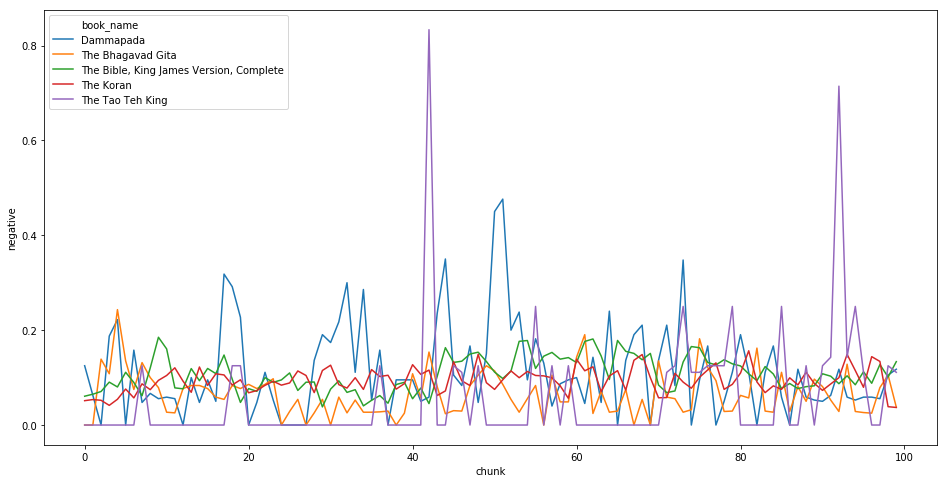

In [65]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='chunk', y='negative', hue="book_name", data=entities_emotion)
plt.show()

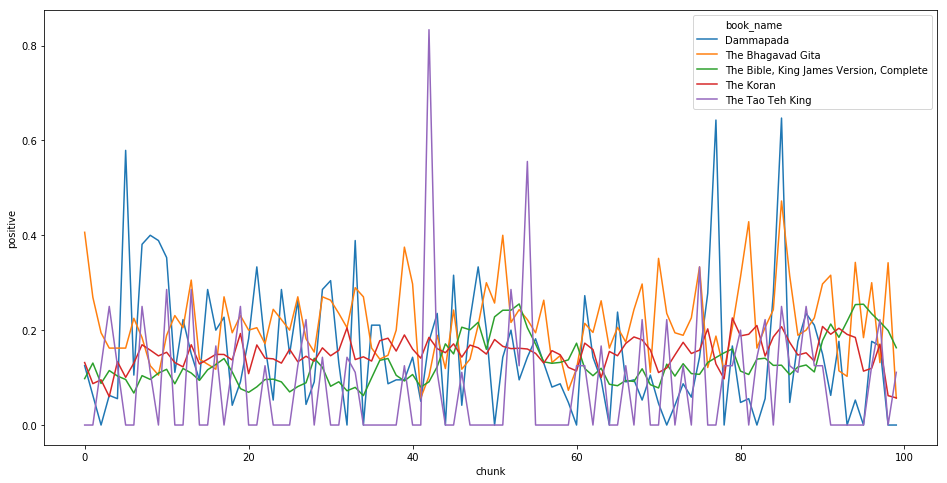

In [66]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='chunk', y='positive', hue="book_name", data=entities_emotion)
plt.show()

## Rough Work

In [71]:
emotions = pd.read_csv("./emotions.csv")

In [72]:
emotions.head()

,religion,book_name,chunk,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,pos_neg
0,buddhism,Dammapada,0,chapter chapter earnestness chapter thought ch...,0.062500,0.0625,0.125000,0.062500,0.000000,0.125000,0.125000,0.062500,0.0000,0.0,0.000000
1,buddhism,Dammapada,1,ter chapter chapter self chapter world chapter...,0.062500,0.0625,0.000000,0.000000,0.062500,0.062500,0.062500,0.000000,0.0000,0.0,0.000000
2,buddhism,Dammapada,2,pter chapter chapter way chapter chapter chapt...,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0625,0.0,0.000000
3,buddhism,Dammapada,3,hought thoughts thoughts man evil thought pain...,0.125000,0.2500,0.125000,0.187500,0.062500,0.187500,0.062500,0.187500,0.0000,0.0,-12.500000
4,buddhism,Dammapada,4,thoughts hatred hatred hatred hatred love wor...,0.222222,0.0000,0.222222,0.222222,0.055556,0.222222,0.055556,0.222222,0.0000,0.0,-16.666667


In [73]:
emotions.pos_neg = (emotions.pos_neg - emotions.pos_neg.mean())/emotions.pos_neg.std()

In [74]:
emotions.head()

,religion,book_name,chunk,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,pos_neg
0,buddhism,Dammapada,0,chapter chapter earnestness chapter thought ch...,0.062500,0.0625,0.125000,0.062500,0.000000,0.125000,0.125000,0.062500,0.0000,0.0,-0.475978
1,buddhism,Dammapada,1,ter chapter chapter self chapter world chapter...,0.062500,0.0625,0.000000,0.000000,0.062500,0.062500,0.062500,0.000000,0.0000,0.0,-0.475978
2,buddhism,Dammapada,2,pter chapter chapter way chapter chapter chapt...,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0625,0.0,-0.475978
3,buddhism,Dammapada,3,hought thoughts thoughts man evil thought pain...,0.125000,0.2500,0.125000,0.187500,0.062500,0.187500,0.062500,0.187500,0.0000,0.0,-1.474756
4,buddhism,Dammapada,4,thoughts hatred hatred hatred hatred love wor...,0.222222,0.0000,0.222222,0.222222,0.055556,0.222222,0.055556,0.222222,0.0000,0.0,-1.807682


In [76]:
emotions.columns[3:]

Index(['text', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust', 'pos_neg'],
      dtype='object')

In [77]:
for col in emotions.columns[4:]:
    emotions[col] = (emotions[col] - emotions[col].mean())/emotions[col].std()

In [81]:
emotions.drop('text', axis=1, inplace=True)

In [86]:
emotions.to_csv(".\emotions.csv", index=False)

In [85]:
emotions["is_negative"] = emotions["pos_neg"]>=0
emotions.head()

,religion,book_name,chunk,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,pos_neg,is_negative
0,buddhism,Dammapada,0,0.358433,-0.195854,1.664072,0.046022,-0.873078,0.469717,-0.214580,0.267016,-0.531490,-1.150718,-0.475978,False
1,buddhism,Dammapada,1,0.358433,-0.195854,-0.680859,-0.874626,-0.062219,-0.313605,-0.821639,-0.837454,-0.531490,-1.150718,-0.475978,False
2,buddhism,Dammapada,2,-0.815865,-0.195854,-0.680859,-0.874626,-0.873078,-1.096928,-1.428697,0.267016,0.284878,-1.150718,-0.475978,False
3,buddhism,Dammapada,3,1.532730,1.867901,1.664072,1.887319,-0.062219,1.253039,-0.821639,2.475955,-0.531490,-1.150718,-1.474756,False
4,buddhism,Dammapada,4,3.359415,-0.883772,3.487907,2.398791,-0.152314,1.688219,-0.889090,3.089549,-0.531490,-1.150718,-1.807682,False


In [87]:
emotions.describe()

,chunk,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,pos_neg
count,500.000000,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,49.500000,-5.817569e-17,-2.494671e-16,-5.950795e-17,4.756195e-16,3.330669e-16,-3.234080e-16,-2.958744e-16,1.558753e-16,3.930190e-17,-4.755085e-16,-6.483702e-17
std,28.894979,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,-8.158646e-01,-8.837720e-01,-6.808589e-01,-8.746261e-01,-8.730784e-01,-1.096928e+00,-1.428697e+00,-8.374538e-01,-5.314898e-01,-1.150718e+00,-6.183278e+00
25%,24.750000,-8.158646e-01,-4.917209e-01,-6.808589e-01,-5.070095e-01,-5.897591e-01,-6.134556e-01,-5.187914e-01,-8.374538e-01,-5.314898e-01,-5.629338e-01,-4.759785e-01
50%,49.500000,-9.795518e-02,-2.341897e-01,-1.760374e-01,-8.750175e-02,-1.627250e-01,-5.135007e-02,-7.967816e-02,-1.137871e-01,-2.026473e-01,-2.191251e-02,-9.549187e-02
75%,74.250000,2.893564e-01,2.195073e-01,2.265191e-01,2.864668e-01,2.572927e-01,3.951409e-01,4.764008e-01,2.109518e-01,1.820472e-02,3.922162e-01,4.861305e-01
max,99.000000,1.260468e+01,8.288473e+00,1.271875e+01,1.140069e+01,9.938385e+00,9.347371e+00,6.665418e+00,1.178505e+01,1.035341e+01,6.784374e+00,4.660591e+00
